In [11]:
%load_ext autoreload
%autoreload 2
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from data_utils import *
import sys

seed = 1337 
np.random.seed(seed)
torch.manual_seed(seed)

sys.path.append('/home/tau/emenier/workspace/miniGPT/')
import miniGPT
data_dir = '/home/tau/emenier/data/AirfRANS/Dataset/'
outfile = 'pointcloud_250_bc.h5'

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
def _colorbar(ax,ola):
    ax_divider = make_axes_locatable(ax)
    # Add an Axes to the right of the main Axes.
    cax = ax_divider.append_axes("right", size="2%", pad=".5%")
    cb = fig.colorbar(ola, cax=cax)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ds = H5CloudDataset(osp.join(data_dir,outfile),return_selector=True)

In [3]:

train_dataset = H5CloudDataset(osp.join(data_dir,outfile),
                               indices=np.arange(9*len(ds)//10),return_selector=True)
val_dataset = H5CloudDataset(osp.join(data_dir,outfile),
                               indices=np.arange(9*len(ds)//10,len(ds)),return_selector=True)

savedir = '/home/tau/emenier/data/AirfRANS/runs/point_run2/'

batch_size = 2 # how many independent sequences will we process in parallel?
lr = 3e-4
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32
size_in = 2+ds.data.attrs['pts_per_bag']*ds.data.attrs['C_in']
size_out = ds.data.attrs['pts_per_bag']*ds.data.attrs['C_out']
D = 768
n_layers = 12
n_heads = 8
dropout = 0.1

print(f'D : {D:}, n_head : {n_heads:}, n_layer : {n_layers:}')

pointformer = miniGPT.ViT.PointCloudTransformer(size_in, size_out, D, n_layers, n_heads, 
                     dropout_freq=0.,
                    gpus_to_split=None,linear_out=False).cuda()

trainer = AirfRANSGPTtrainer(pointformer,lr,
                    checkpoint_path=savedir,wd=0.,parallel=True)
loader = miniGPT.train_utils.MyLoader(val_dataset,batch_size,len(ds)//2,torch.device('cpu'))


D : 768, n_head : 8, n_layer : 12


Model Numbers : 
   Context   :    0 tokens
   Embedding :  768 tokens
   Layers    :   12
   Heads     :    8
   Params    : 87 M


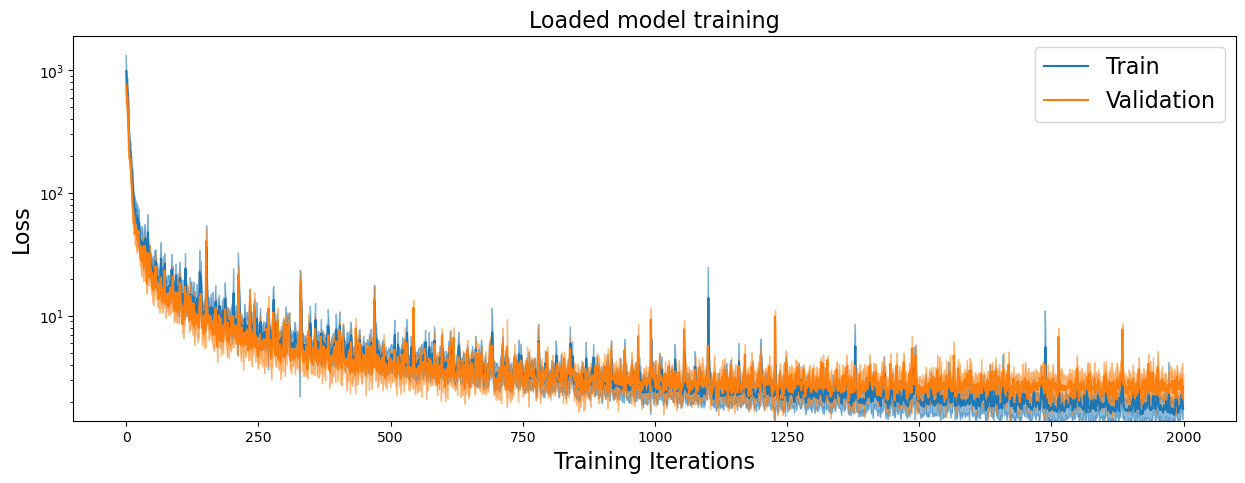

In [37]:
dic = trainer.load('last_model.trch')
trainer.gpt_model.eval()
miniGPT.plot_utils.model_numbers(pointformer,0,n_layers,D, n_heads)
miniGPT.plot_utils.plot_losses(dic)

Min pred = -61.6 - Max pred = 131.3 - Max Error = 7.09e+01 - U_e = 9.68e+01 - Pred_e = 2.59e+01


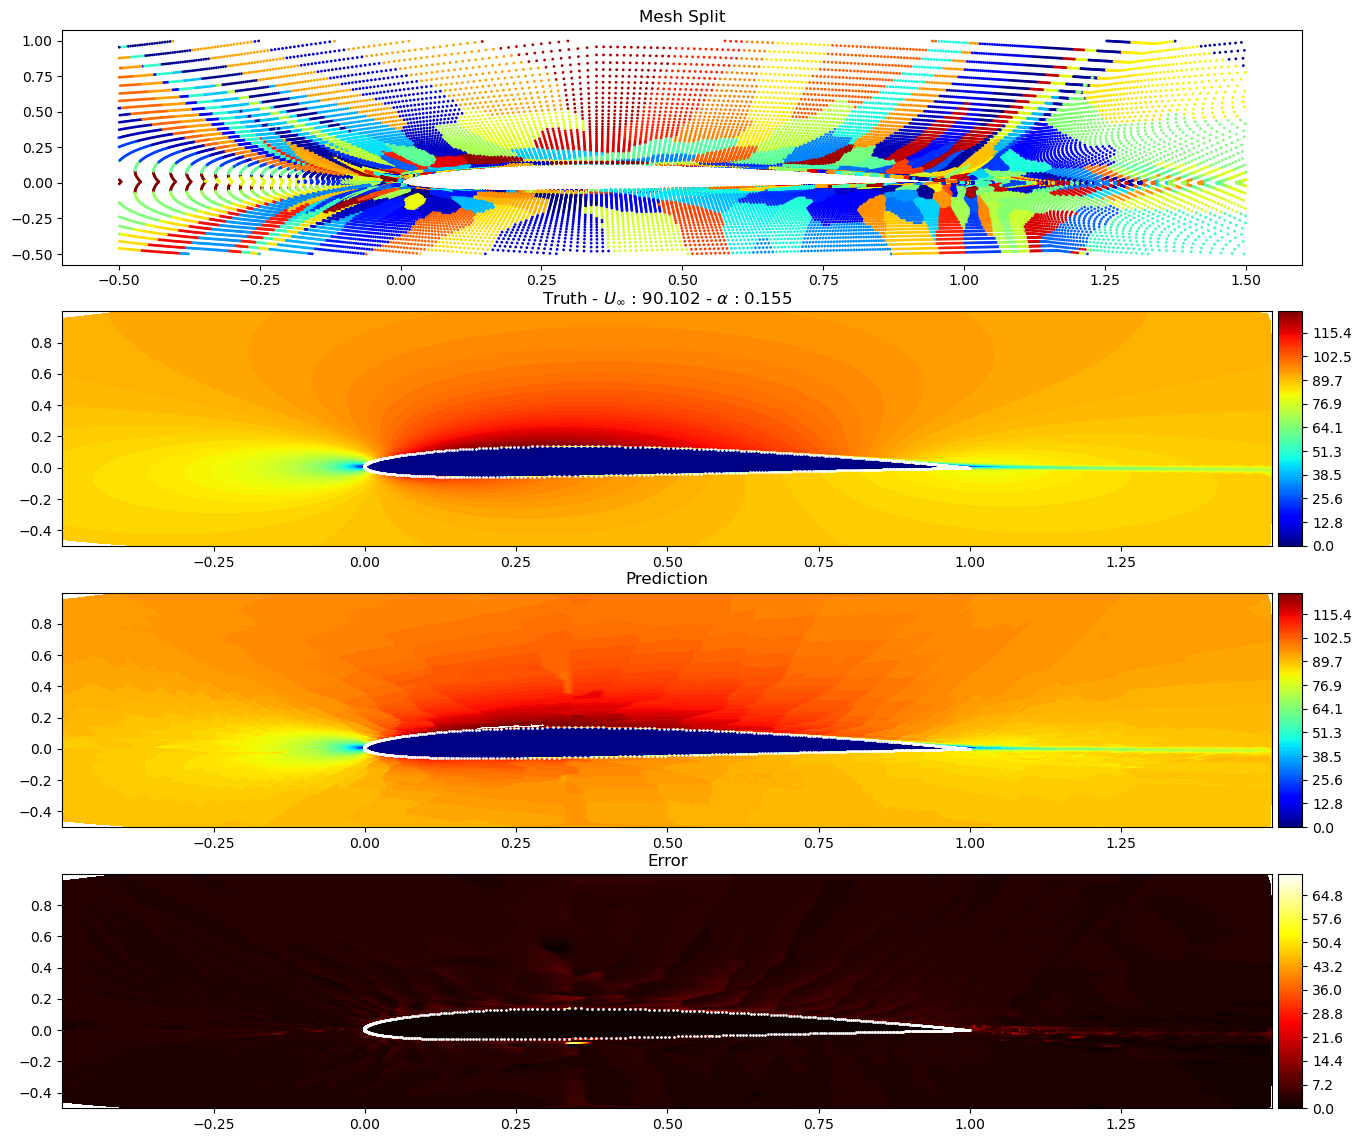

In [40]:
C_in, C_out = ds.data.attrs['C_in'], ds.data.attrs['C_out']
loader = miniGPT.train_utils.MyLoader(val_dataset,batch_size,len(ds)//2,torch.device('cpu'))

patches_in, patches_out, mask, selector = next(loader)
pred = pointformer.predict(patches_in.cuda(),mask.cuda()).detach().cpu().numpy()

patches_out[mask] = 0.
zero_patches = to_point_cloud(selector[0]*mask[0],patches_in[0,...,2:].cpu().numpy(),
                              C=C_out,C_patches=C_in)
mask = mask.cpu().numpy()
coords = to_point_cloud(selector[0],patches_in[0,...,2:].cpu().numpy(),
                              C=C_out,C_patches=C_in)[:,:2]
vals = to_point_cloud(selector[0],patches_out[0].cpu().numpy(),
                              C=C_out,C_patches=C_out)
pred_pc = to_point_cloud(selector[0],pred[0],
                              C=C_out,C_patches=C_out)

bag_idx = np.random.choice(patches_in.shape[1],size=patches_in.shape[1], replace=False)
bag_idx = torch.tensor(bag_idx).reshape(-1,1).repeat(1,patches_in[...,2:].shape[2])
bag_indices = to_point_cloud(selector[0],bag_idx,
                              C=C_out,C_patches=C_in)[:,0]

uvals = np.linalg.norm(vals,axis=-1)
levels= np.linspace(uvals.min(),uvals.max(),100)

fig, (ax4,ax1,ax2,ax3) = plt.subplots(nrows=4,figsize=(16,14))

ax4.set_title('Mesh Split')
ax4.scatter(*coords.T,c=bag_indices,s=1,cmap=plt.cm.jet)

ax1.set_title(fr'Truth - $U_\infty$ : {patches_in[0,0,0].item():.3f} - $\alpha$ : {patches_in[0,0,1].item():.3f}')
#ax1.scatter(coords[:,0],coords[:,1],s=1,c=np.linalg.norm(vals,axis=-1),cmap=plt.cm.jet)
ola=ax1.tricontourf(coords[:,0],coords[:,1],uvals,levels=levels,cmap=plt.cm.jet)
ax1.scatter(zero_patches[:,0],zero_patches[:,1],s=1,color='white')
_colorbar(ax1,ola)

ax2.set_title('Prediction')
ola=ax2.tricontourf(coords[:,0],coords[:,1],np.linalg.norm(pred_pc,axis=-1),levels=levels,cmap=plt.cm.jet)
ax2.scatter(zero_patches[:,0],zero_patches[:,1],s=1,color='white')
_colorbar(ax2,ola)
ax3.set_title('Error')

error = pred_pc-vals
error_norm = np.linalg.norm(error,axis=-1)
idx = np.argmax(error_norm)
print(f'Min pred = {pred.min():.1f} - Max pred = {pred.max():.1f} - Max Error = {error_norm[idx]:.2e}\
 - U_e = {uvals[idx]:.2e} - Pred_e = {np.linalg.norm(pred_pc[idx]):.2e}')
ola=ax3.tricontourf(coords[:,0],coords[:,1],np.linalg.norm(error,axis=-1),100,cmap=plt.cm.hot)
_colorbar(ax3,ola)
ax3.scatter(zero_patches[:,0],zero_patches[:,1],s=1,color='white')
#ax3.scatter(*coords[idx],s=100,color='blue')